In [1]:
import pandas as pd

#gta = pd.read_csv('C:\\Users\\admin\\Documents\\GTA_Plots\\GTA_reduceData.csv', header=-1, dtype={"time": DatetimeIndex, "idsession": int, "scenario" : int, "speed" : float, "nextpedestrianrunning" : int, "nextpedestrianid" : int})

#steering = pd.read_csv('C:\\Users\\admin\\Documents\\GTA_Plots\\steeringData.csv', header=-1)
import psycopg2


In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap

In [3]:
# Define our connection string
conn_string = "host='localhost' port='5432' dbname='GTA' user='postgres'"

# print the connection string we will use to connect
print ("Connecting to database\n	->")

# get a connection, if a connect cannot be made an exception will be raised here
conn = psycopg2.connect(conn_string)

# conn.cursor will return a cursor object, you can use this cursor to perform queries
cursor = conn.cursor()
print( "Connected!\n" )

#cursor.execute('SELECT * FROM  public."GTA_DataView";')

Connecting to database
	->


OperationalError: FATAL:  role "postgres" does not exist


In [ ]:
cursor.execute('SELECT time, idsession, scenario,' +
               ' SUM(CASE data_type_id WHEN 1 THEN value ELSE 0 END) as posX,' +
               'SUM(CASE data_type_id WHEN 2 THEN value ELSE 0 END) as posY,' +
               ' SUM(CASE data_type_id WHEN 10 THEN value ELSE 0 END) as hadCollision,'+
               ' SUM(CASE data_type_id WHEN 17 THEN value ELSE 0 END) as pedId,'+
               ' SUM(CASE data_type_id WHEN 15 THEN value ELSE 0 END) as nextPedRunning,'+
               ' SUM(CASE data_type_id WHEN 11 THEN value ELSE 0 END) as distancePed,'+
                ' SUM(CASE data_type_id WHEN 8 THEN value ELSE 0 END) as speed,'+
                ' SUM(CASE data_type_id WHEN 12 THEN value ELSE 0 END) as posPedX,'+
                ' SUM(CASE data_type_id WHEN 13 THEN value ELSE 0 END) as posPedY,'+
               ' SUM(CASE data_type_id WHEN 596 THEN value ELSE 0 END) as currentDistance'+
               ' FROM datagta gta WHERE gta.idsession >= 144 AND gta.data_type_id in (1,2,8,10,11,12,13,15,17,596)'+
               ' AND gta.idsession not in (145,146,147,148,149,151,155,158,162,164)'+
               ' GROUP BY time, idsession, scenario;')
rows = cursor.fetchall()
timestamps = [row[0] for row in rows]
if (len(timestamps) == 0):
    print ("Something went wrong")
firstTime = timestamps[:1][0]
lastTime = timestamps[-1:][0]
dfGTA = pd.DataFrame(rows, index=timestamps)
#dfDiffGTA = dfGTA.diff()
dfGTA.columns=['time','session_id','scenario', 'Pos_X', 'Pos_Y', 'hadCollision', 'pedId', 'nextPedRunning', 'distancePed','speed', 'posPedX', 'posPedY' , 'currentDistance']
#dfGTA

#print ("Abstract \n Distractions and inattentions are very important in order to reduce the road accidents. Is difficult to recognize while the driver is driving a vehicle because you can only have access to a few particular data. In this experiment we used almost the same data that we can collected in a normal car (e.g. throttle, brake, steering, etc.) and immerse the driver in different environments trying to be attentive and respecting all the traffic rules, while we can see how react this driver to the changes we purpose in the virtual simulation. Since the real reaction time of a driver involved in an accident will always be unknown to reconstruction experts, we decided to make our personal virtual environment where we test the driver's attention, and have the results from our virtual accidents so we can find the possibles causes to it with the same data we can have in a real situation.")
dfGTA

In [ ]:
cursor.execute('SELECT time, idsession, scenario,' +
               ' SUM(CASE data_type_id WHEN 1 THEN value ELSE 0 END) as Steering,' +
               'SUM(CASE data_type_id WHEN 2 THEN value ELSE 0 END) as Brake,' +
               ' SUM(CASE data_type_id WHEN 3 THEN value ELSE 0 END) as Throttle '+
               ' FROM datasteering gta WHERE gta.idsession >= 144 AND gta.data_type_id in (1,2,3)'+
               ' AND gta.idsession not in (145,146,147,148,149,151,155,158,162,164) '+
               ' GROUP BY time, idsession, scenario;')
rows = cursor.fetchall()
timestamps = [row[0] for row in rows]
df_steer = pd.DataFrame(rows, index=timestamps)
df_steer.columns=['time2','session_id','scenario', 'steering', 'brake',  'throttle']
freq_resample = '50000U'
df_steer = df_steer.resample(freq_resample).ffill()
freq_resample = '50000U'
dfGTA = dfGTA.resample(freq_resample).ffill()
steer = df_steer.drop(df_steer.columns[[1, 2]], axis=1)
df_joined = pd.concat([dfGTA, steer], axis=1, join='inner')

In [ ]:
df_joined['steering'] = df_joined['steering'].divide(65535)
df_joined['brake'] = df_joined['brake'].divide(65535)
df_joined['throttle'] = df_joined['throttle'].divide(65535)
df_joined['acceleration'] = df_joined['speed'].diff()
df_joined = df_joined[(df_joined.pedId != 16)  & (df_joined.pedId != 17)  & (df_joined.speed > 0)  & (df_joined.scenario != 7) & (df_joined.scenario != 8)]


In [4]:
#pedCross = dfGTA[(dfGTA.nextPedRunning == True) & (dfGTA.distancePed < 20)  & (dfGTA.scenario != 7) & (dfGTA.scenario != 8)]
#df_joined['acceleration'] = df_joined['speed'].diff()
#df_joined = df_joined[~df_joined.index.duplicated()]
means = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).mean()
#clean the ones in which didnt run the pedestrian
means = means[means.nextPedRunning != 0]
first = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
last = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).last()
#plot(means['steering'])
pedCross = df_joined[(df_joined.nextPedRunning == True)]
firstPedCross = pedCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
lastPedCross = pedCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).last()



NameError: name 'df_joined' is not defined

In [5]:
means[means.nextPedRunning == 0]

NameError: name 'means' is not defined

In [ ]:
means_cleaned = means.drop(means.columns[[3,4,6,7,9,10,11]], axis=1)

#means_cleaned = means.dropna(thresh=11)
#df_joined = df_joined[df_joined.notnull()]
#session_id	scenario	pedId	hadCollision speed		steering	brake	throttle	acceleration
means_cleaned['hadCollision'] = np.where(means_cleaned['hadCollision'] == 0, False, True)

#means_cleaned.drop(means_cleaned[means_cleaned.nextPedRunning == 0])
means_cleaned

In [24]:
firstPedCross['timeFinal'] = lastPedCross['time']
firstPedCross['diff'] = firstPedCross['timeFinal'] - firstPedCross['time']
finalDataPedCross =  firstPedCross.drop(firstPedCross.columns[[3,4,5,6,7,10,11,12,13,14,15,16,18]], axis=1)
#session_id	scenario	pedId	distancePed	speed	throttle	acceleration	diff
finalDataPedCross

,session_id,scenario,pedId,distancePed,speed,acceleration,diff
0,144.0,1.0,1.0,23.562530,7.754880,0.084366,00:00:05.239119
1,144.0,1.0,3.0,39.895280,13.472353,-0.004603,00:00:07.705014
2,144.0,1.0,15.0,49.374313,25.585112,0.066917,00:00:07.848389
3,144.0,2.0,0.0,7.474411,2.517837,0.101637,00:00:01.202199
4,144.0,2.0,2.0,49.291360,19.412087,0.047970,00:00:04.975241
5,144.0,2.0,4.0,49.635360,18.461056,0.000889,00:00:04.976247
6,144.0,2.0,5.0,48.662006,14.120423,0.192024,00:00:03.491809
7,144.0,2.0,6.0,48.876648,15.858500,0.183195,00:00:08.389330
8,144.0,2.0,7.0,31.952600,10.126199,0.341626,00:00:03.998641
9,144.0,2.0,9.0,48.481934,22.738840,0.069643,00:00:02.198851


In [27]:

#firstPedCross['timeFinal'] = lastPedCross['time']
#firstPedCross
#lastPedCross['time']
#time = np.delete(firstPedCross['time'], 1, 1)
#time
#firstPedCross[firstPedCross.columns[[3,18]]]
#firstPedCross['diff'] = np.diff(firstPedCross[firstPedCross.columns[[3,18]]], axis=0)
#firstPedCross['diff'] = firstPedCross['timeFinal'] - firstPedCross['time']
#np.diff(firstPedCross[firstPedCross.columns[[3,18]]], axis=0)
#firstPedCross
#finalData = means_cleaned
#finalData = means_cleaned.join(firstPedCross.set_index(['session_id', 'scenario', 'pedId']), on=['session_id', 'scenario', 'pedId'])
#finalData = pd.concat([means_cleaned, firstPedCross], axis=1, join='inner')
finalData = pd.merge(means_cleaned, finalDataPedCross, how='inner', on=['session_id', 'scenario', 'pedId'])

#finalData['distanciaEmpezoACorrer'] = firstPedCross['distancePed']
#finalData['TiempoEmpezoACorrer'] = firstPedCross['diff']
#finalData['VelocidadEmpezoACorrer'] = firstPedCross['speed']
#finalData['AceleracionEmpezoACorrer'] = firstPedCross['acceleration']
#finalData['AceleradorEmpezoACorrer'] = firstPedCross['throttle']


finalData.to_csv("experimentosPorPeaton.csv")
#np.savetxt("experimentosPorPeaton.csv", finalData,fmt='%14s', delimiter=",")
finalData

,session_id,scenario,pedId,hadCollision,speed_x,steering,brake,throttle,acceleration_x,distancePed,speed_y,acceleration_y,diff
0,144.0,1.0,1.0,False,5.919151,0.503649,0.965743,0.820576,0.030684,23.562530,7.754880,0.084366,00:00:05.239119
1,144.0,1.0,3.0,False,7.580378,0.499771,0.891302,0.878839,-0.026652,39.895280,13.472353,-0.004603,00:00:07.705014
2,144.0,1.0,15.0,True,9.474048,0.494557,0.952182,0.781126,0.006295,49.374313,25.585112,0.066917,00:00:07.848389
3,144.0,2.0,0.0,False,3.398595,0.523305,0.960227,0.858795,0.027367,7.474411,2.517837,0.101637,00:00:01.202199
4,144.0,2.0,2.0,False,11.669419,0.500661,0.891913,0.522365,0.008028,49.291360,19.412087,0.047970,00:00:04.975241
5,144.0,2.0,4.0,False,12.187044,0.499769,0.861132,0.558120,0.001881,49.635360,18.461056,0.000889,00:00:04.976247
6,144.0,2.0,5.0,False,13.122751,0.486196,0.885589,0.588215,-0.046148,48.662006,14.120423,0.192024,00:00:03.491809
7,144.0,2.0,6.0,True,7.312292,0.515226,0.806024,0.644513,-0.030441,48.876648,15.858500,0.183195,00:00:08.389330
8,144.0,2.0,7.0,False,6.860759,0.504635,0.913683,0.455162,0.048794,31.952600,10.126199,0.341626,00:00:03.998641
9,144.0,2.0,9.0,False,19.140068,0.502979,1.000000,0.322693,0.147312,48.481934,22.738840,0.069643,00:00:02.198851


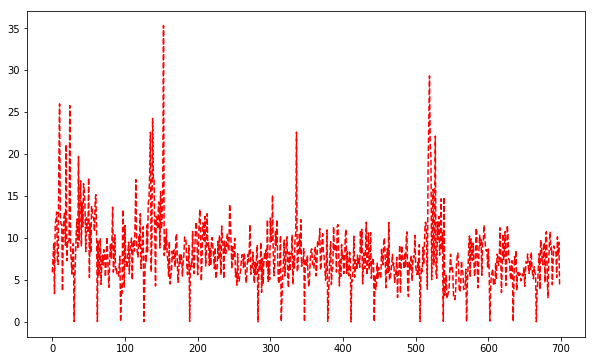

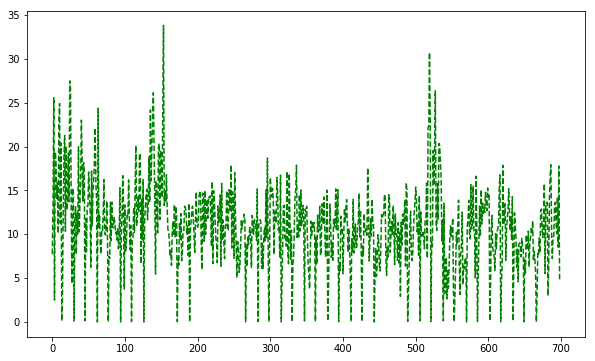

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(finalData.speed_x,'r--')
#plt.savefig('brake_distance_zoom.pdf')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(finalData.speed_y, 'g--')
#plt.savefig('brake_distance_zoom.pdf')
plt.show()

In [48]:
df_joined

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,time,steering,brake,throttle,acceleration
2017-10-04 12:50:28.400,2017-10-04 12:50:28.383484,144.0,1.0,-975.703700,82.260376,0.0,1.0,0.0,89.979675,0.013278,-885.689200,70.213150,1253.459000,2017-10-04 12:50:28.384988,0.492973,1.0,1.000000,NaN
2017-10-04 12:50:28.450,2017-10-04 12:50:28.437127,144.0,1.0,-975.709534,82.251080,0.0,1.0,0.0,89.984790,0.135856,-885.689200,70.213150,1253.464000,2017-10-04 12:50:28.444647,0.492973,1.0,1.000000,0.122578
2017-10-04 12:50:28.500,2017-10-04 12:50:28.494279,144.0,1.0,-975.714233,82.246090,0.0,1.0,0.0,89.988880,0.125762,-885.689200,70.213150,1253.468140,2017-10-04 12:50:28.484754,0.492973,1.0,1.000000,-0.010094
2017-10-04 12:50:28.550,2017-10-04 12:50:28.520850,144.0,1.0,-975.716000,82.244156,0.0,1.0,0.0,89.990330,0.102796,-885.689200,70.213150,1253.469600,2017-10-04 12:50:28.544914,0.492973,1.0,1.000000,-0.022966
2017-10-04 12:50:28.600,2017-10-04 12:50:28.584519,144.0,1.0,-975.718100,82.241540,0.0,1.0,0.0,89.991715,0.047856,-885.689200,70.213150,1253.471680,2017-10-04 12:50:28.585020,0.492973,1.0,1.000000,-0.054940
2017-10-04 12:50:28.650,2017-10-04 12:50:28.640168,144.0,1.0,-975.718500,82.240715,0.0,1.0,0.0,89.991420,0.022100,-885.689200,70.213150,1253.471920,2017-10-04 12:50:28.644679,0.492973,1.0,1.000000,-0.025756
2017-10-04 12:50:28.700,2017-10-04 12:50:28.689298,144.0,1.0,-975.718700,82.240970,0.0,1.0,0.0,89.991080,0.023997,-885.689200,70.213150,1253.471920,2017-10-04 12:50:28.684786,0.492973,1.0,1.000000,0.001896
2017-10-04 12:50:28.750,2017-10-04 12:50:28.738930,144.0,1.0,-975.719238,82.241066,0.0,1.0,0.0,89.991005,0.016500,-885.689200,70.213150,1253.472660,2017-10-04 12:50:28.744946,0.492973,1.0,1.000000,-0.007496
2017-10-04 12:50:28.800,2017-10-04 12:50:28.774524,144.0,1.0,-975.719666,82.240980,0.0,1.0,0.0,89.991050,0.013840,-885.689200,70.213150,1253.473000,2017-10-04 12:50:28.785052,0.492973,1.0,1.000000,-0.002661
2017-10-04 12:50:28.850,2017-10-04 12:50:28.812626,144.0,1.0,-975.720100,82.240880,0.0,1.0,0.0,89.991080,0.010973,-885.689200,70.213150,1253.473390,2017-10-04 12:50:28.844711,0.492973,1.0,1.000000,-0.002867


In [11]:

df_joined_clean = df_joined.drop(df_joined.columns[[1,2,6,12,13]], axis=1)
df_joined_clean = df_joined_clean.dropna(thresh=11)
#df_joined = df_joined[df_joined.notnull()]
df_joined_clean

,Pos_X,Pos_Y,hadCollision,nextPedRunning,distancePed,speed,posPedX,posPedY,steering,brake,throttle
2017-10-04 12:46:18.100,-975.749500,82.249620,0.0,0.0,70.352844,0.000000,154.041500,-23.487390,33096.0,65535.0,65535.0
2017-10-04 12:46:18.150,-975.749500,82.249620,0.0,0.0,70.352844,0.000000,154.041500,-23.487390,33096.0,65535.0,65535.0
2017-10-04 12:46:18.200,-975.749500,82.249620,0.0,0.0,70.352844,0.000000,154.041500,-23.487390,33096.0,65535.0,65535.0
2017-10-04 12:46:18.250,-975.749500,82.249620,0.0,0.0,70.352844,0.000000,154.041500,-23.487390,33096.0,65535.0,65535.0
2017-10-04 12:46:18.300,-975.708100,82.252920,0.0,0.0,70.352844,0.128202,154.041500,-23.487390,33096.0,65535.0,65535.0
2017-10-04 12:46:18.350,-975.711365,82.249176,0.0,0.0,70.352844,0.142761,154.041500,-23.487390,33096.0,65535.0,65535.0
2017-10-04 12:46:18.400,-975.716000,82.244530,0.0,0.0,70.352844,0.108481,154.041500,-23.487390,33096.0,65535.0,65535.0
2017-10-04 12:46:18.450,-975.718300,82.241750,0.0,0.0,70.352844,0.056718,154.041500,-23.487390,33096.0,65535.0,65535.0
2017-10-04 12:46:18.500,-975.718750,82.241060,0.0,0.0,70.352844,0.033677,154.041500,-23.487390,33096.0,65535.0,65535.0
2017-10-04 12:46:18.550,-975.718900,82.240780,0.0,0.0,70.352844,0.025107,154.041500,-23.487390,33096.0,65535.0,65535.0


In [20]:
#speedAverageScenario
rateHit = [10.0/(24*4), 20.0/(24*12) ,12.0/(24*6) ,10.0/(24*6), 0 ,15.0/(24*6)]
pedHitPerSession = {}
for pedHit in pedsHit:
    session, scenario, pedId = pedHit
    if (pedId == 16 or pedId == 17):
        continue
    if session in pedHitPerSession:
        if scenario in pedHitPerSession[session]:
            pedHitPerSession[session][scenario] += rateHit[int(scenario-1)]
        else:
            pedHitPerSession[session][scenario] = rateHit[int(scenario-1)]
    else:
        pedHitPerSession[session] = {}
        pedHitPerSession[session][scenario] = rateHit[int(scenario-1)]
        
#pedsHit
#pedHitPerSession

In [21]:
speedAverageScenario = (dfGTA.groupby(['session_id', 'scenario'], as_index=False)['speed'].mean())
speeds = []
speedsPerScenario = {}
pedRatePerScenario = {}
pedRates = []
scenariosSpeedPed = []
for fila in speedAverageScenario.iterrows():
    idfila, filacompleta = fila
    session = filacompleta[0]
    scenario = filacompleta[1]
    speed = filacompleta[2]
    speeds.append(speed)
    rate = pedHitPerSession.get(session, 0)
    if (rate != 0):
        rate = rate.get(scenario, 0)
    pedRates.append(rate)
    scenariosSpeedPed.append(scenario)
    if scenario in speedsPerScenario:
        lista = (speedsPerScenario[scenario])
        #print type(lista)
        lista.append(speed)
        speedsPerScenario[scenario] = lista
    else:
        speedsPerScenario[scenario] = [speed]
    if scenario in pedRatePerScenario:
        lista = pedRatePerScenario[scenario]
        lista.append(rate)
        pedRatePerScenario[scenario] = lista
    else:
        pedRatePerScenario[scenario] = [rate]
    #speedsPerScenario[scenario] = (speedsPerScenario.get(scenario, [])).append(speed)
    #pedRatePerScenario[scenario] = (pedRatePerScenario.get(scenario, [])).append(rate)
    


In [22]:
pedCross = dfGTA[(dfGTA.nextPedRunning == True) & (dfGTA.distancePed < 20)  & (dfGTA.scenario != 7) & (dfGTA.scenario != 8)]
firstPedCross = pedCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
lastPedCross = pedCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).last()
lastPedCross


def pedCross(midPoint, PedPosIniX,PedPosIniY , PedPosFinX,PedPosFinY ):
    if (PedPosIniX > PedPosFinX):
        maxX = PedPosIniX
        minX = PedPosFinX
    else:
        minX = PedPosIniX
        maxX = PedPosFinX
    if (PedPosIniY > PedPosFinY):
        maxY = PedPosIniY
        minY = PedPosFinY
    else:
        minY = PedPosIniY
        maxY = PedPosFinY
    if (minX <= midPoint[0] <= maxX or minY <= midPoint[1] <= maxY):
        return True
    return False

pedInfo = []

for filaPedCross in firstPedCross.iterrows():
    session = filaPedCross[1][0]
    scenario = filaPedCross[1][1]
    pedId = filaPedCross[1][2]
    posx = filaPedCross[1][4]
    posy = filaPedCross[1][5]
    posPedIniX = filaPedCross[1][10]
    posPedIniY = filaPedCross[1][11]
    posPedFinX = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]["posPedX"]
    posPedFinY = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]["posPedY"]
    
    posPedFinX2 = posPedFinX.iloc[0]
    posPedFinY2 = posPedFinY.iloc[0]
    #print posPedFinX2, posPedFinY2
    pedHit = ((session, scenario, pedId) in pedsHit)
    pedCrossed = pedCross([posx, posy], posPedIniX, posPedIniY, posPedFinX2, posPedFinY2)
    tupla = (session,scenario,pedId,pedHit, pedCrossed)
    pedInfo.append(tupla)
    
#pedInfo
#tuplelist2dict = {a: rest for a, *rest in pedInfo}
#tuplelist2dict
#lastPedCross[(lastPedCross.session_id == 144) & (lastPedCross.pedId == 3)  & (lastPedCross.scenario == 1)]["Pos_X"]

In [23]:
i = 0
pedInfoRateCrossed = []
hitCrossPerSession = {}
while (i < len(pedInfo)):
    session = pedInfo[i][0]
    sessionAct = pedInfo[i][0]
    hitCrossPerSession[sessionAct] = {}
    while (sessionAct == session):
        scenario = pedInfo[i][1]
        scenarioAct = pedInfo[i][1]
        hitCrossPerSession[sessionAct][scenarioAct] = {}
        totalHits = 0
        totalCrossed = 0
        while (scenario == scenarioAct): 
            if (pedInfo[i][2] == 16 or pedInfo[i][2] == 17):
                i += 1
                continue
            hitCrossPerSession[sessionAct][scenarioAct][pedInfo[i][2]] = (pedInfo[i][3], pedInfo[i][4])
            if (pedInfo[i][3]):
                totalHits += 1
            if (pedInfo[i][4]):
                totalCrossed += 1
            i += 1
            if (i >= len(pedInfo)):
                break
            scenarioAct = pedInfo[i][1]
        if (totalCrossed != 0):
            pedInfoRateCrossed.append((session, scenario, float(totalHits)/totalCrossed))
        if (i >= len(pedInfo)):
                break
        sessionAct = pedInfo[i][0]
pedInfoRateCrossedPerScenario = [[], [], [], [], [], [], []]
pedInfoSpeedCrossedPerScenario = [[], [], [], [], [], [], []]

for rates in pedInfoRateCrossed:
    pedInfoRateCrossedPerScenario[int(rates[1])].append(rates[2])

#print len(pedInfoRateCrossedPerScenario[1])
#print len(speedsPerScenario[1])
#speedsPerScenario
#hitCrossPerSession

In [34]:
hitsPerPed = {}
for info in pedInfo:
    anomNew = 0
    hitNew = 0
    totalNew = 0
    if (info[4] == True):
        totalNew += 1
        if (info[3] == True):
            hitNew += 1
    else:
        if (info[3] == True):
            anomNew += 1
    
    if info[2] in hitsPerPed:
        anom, hit, total = hitsPerPed[(info[2])]
        hitsPerPed[(info[2])] = (anom + anomNew, hit + hitNew, total + totalNew)
    else:
        hitsPerPed[(info[2])] = (anomNew, hitNew, totalNew)
        

hitsPerPed.pop(16, None)
hitsPerPed.pop(17, None)
#hitsPerPed
lists = sorted(hitsPerPed.items()) # sorted by key, return a list of tuples
#print (lists)
x, y = zip(*lists) # unpack a list of pairs into two tuples
anom, hit, total = zip(*y) # unpack a list of pairs into two tuples
print (anom)
print (total[3])
i=0
anomRate = []
hitRate = []
for tot in total:
    anomRate.append( anom[i]/tot)
    hitRate.append(  hit[i]/tot )
    i += 1
    


(5, 2, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 4)
14


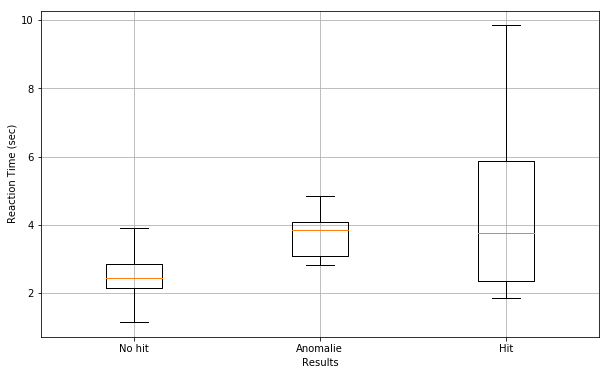

In [42]:
# don't show outlier points
#speedAverageScenario
labels = ["No hit","Anomalie","Hit"]
scenarios = [1,2,3,4,6,7,8]
#speedAverageScenario[speedAverageScenario.scenario == 1]

datos = []

datos.append(np.array(dataReactionBNoHit))
datos.append(np.array(dataReactionBAlmostHit))
datos.append(np.array(dataReactionBHit))


#data = np.concatenate((speedAverageScenario['scenario'], speedAverageScenario['speed']), 0)
#plt.boxplot(data, 0, '')
plt.figure(figsize=(10, 6))
plt.boxplot(datos,0, '')
plt.ylabel("Reaction Time (sec)")
plt.xlabel("Results")
plt.xticks([1,2,3], labels)
#plt.savefig('ResultsAndReactionTimeBoxPlot.pdf')
plt.grid(True)
plt.show()